# Learning Narrow Passages
### With conditional autoencoder

## Setup

In [1]:
# Import libraries
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import numpy as np
import os
import matplotlib.pyplot as plt

# Import local
from model import CVAE

# Use Cuda if possible
print("Cuda available?  {}".format(torch.cuda.is_available()))
print("Cuda version: {}".format(torch.version.cuda))
try:
    device = torch.device("cuda")
    torch.ones(5).to("cuda")
except:
    print("Cuda failed to work! Using CPU...")
    device = torch.device("cpu")

Cuda available?  True
Cuda version: 10.2


In [2]:
# Options
TRAIN_MODEL = True # Train? or just test existing?
SAVE_MODEL = True  # Should save the model?
MODEL_PATH = "out/LinearNarrowPassages_example.pt"
printFreq = 100

# Hyperparams: training
trainProp = 0.8
batchSize = 256
epochs = 300000
learnRate = 1e-4 

# Hyperparams: network
hiddenEncoderSize = 512
hiddenDecoderSize = 512
latentSize = 3

In [3]:
#Load data
dataFile = "LinearNarrowPassages_Data.npz"
data = np.load(dataFile)
xData = data["x"]
cData = data["c"]
nEntries = xData.shape[0]

# Split into train, test
nTrain = int(nEntries * trainProp)
xTrain = xData[0:nTrain, :]
cTrain = cData[0:nTrain, :]
xTest  = xData[nTrain:, ]
cTest  = cData[nTrain:, ] 

print("Loaded data:")
print("  File: {}".format(dataFile))
print("  Samples (x) shape: {}".format(xData.shape))
print("  Conditions (c) shape: {}".format(cData.shape))
print("  Training: {},   testing: {}".format(xTrain.shape[0], xTest.shape[0]))

Loaded data:
  File: LinearNarrowPassages_Data.npz
  Samples (x) shape: (83731, 6)
  Conditions (c) shape: (83731, 133)
  Training: 66984,   testing: 16747


In [4]:
# Create data loaders
def makeDataLoader(x, c, batchSize):
    xTensor = torch.Tensor(x)
    cTensor = torch.Tensor(c)
    dataset = TensorDataset(xTensor, cTensor)
    dataLoader  = DataLoader(dataset, batch_size=batchSize, shuffle=True)
    return xTensor, cTensor, dataset, dataLoader
    
xTrainTensor, cTrainTensor, trainDataset, trainDataLoader = \
    makeDataLoader(xTrain, cTrain, batchSize)

xTestTensor, cTestTensor, testDataset, testDataLoader = \
    makeDataLoader(xTest, cTest, batchSize)


## Train

In [5]:
# Define loss function
def loss_fn(reconstructed_x, x, mu, logvar, weight):
    # Reconstruction + KL divergence loss 
    
    def weightedMSE(pred, target, weight):
        return (weight * (pred - target) ** 2).mean()
    def MSE(pred, target):
        return torch.sum((pred - target) ** 2)
    
    # Reconstruction loss
    recon_loss = weightedMSE(reconstructed_x, x, weight)
    
    # KL divergence loss
    KL_loss = 10**-4 * 2 * torch.sum(torch.exp(logvar) + mu**2 - 1.0 - logvar, 1)
    
    return torch.mean(recon_loss + KL_loss)

# Define batch training
def train(model, optimizer, dataLoader, weight, device="cpu"):
    weight = weight.to(device)
    model.train()
    train_loss = 0
    for batch_idx, (X, C) in enumerate(dataLoader):
        X, C = X.to(device), C.to(device)
        q_z, logvar, mu, z = model(X, C)
        optimizer.zero_grad()
        cvae_loss = loss_fn(q_z, X, mu, logvar, weight[0:X.shape[0], :]) 
        cvae_loss.backward()
        train_loss += cvae_loss
        optimizer.step()
    return train_loss / X.shape[0]
    

# Define batch testing
def test(model, dataLoader, weight, device="cpu"):
    weight = weight.to(device)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (X, C) in enumerate(dataLoader):
            X, C = X.to(device), C.to(device)
            q_z, logvar, mu, z = model(X, C)
            cvae_loss = loss_fn(q_z, X, mu, logvar, weight[0:X.shape[0], :])
            test_loss += cvae_loss
    return test_loss / X.shape[0]

In [6]:
# Init model
model = CVAE(
    sample_size = xTrain.shape[1],
    condition_size = cTrain.shape[1],
    hidden_encoder_size = hiddenEncoderSize,
    hidden_decoder_size = hiddenDecoderSize,
    latent_size = latentSize,
).to(device)

# Init optimizer
optimizer = optim.Adam(model.parameters(), lr=learnRate)

# MSE weight
weight = np.array([1.0, 1.0, 1.0, 0.5, 0.5, 0.5])
weight = torch.Tensor(np.tile(weight, (batchSize, 1)))

In [7]:
if TRAIN_MODEL:
    # Train
    for epoch in range(epochs):
        train_loss = train(model, optimizer, trainDataLoader, weight, device=device)
        if epoch % printFreq == 0:
            print("Epoch: {},  Mean loss: {:.4f}".format(epoch, train_loss))
            
    if SAVE_MODEL:
        torch.save(model, MODEL_PATH)
else:
    # Load model
    model = torch.load(MODEL_PATH)

Epoch: 0,  Mean loss: 0.1466
Epoch: 100,  Mean loss: 0.0208
Epoch: 200,  Mean loss: 0.0177
Epoch: 300,  Mean loss: 0.0162
Epoch: 400,  Mean loss: 0.0153
Epoch: 500,  Mean loss: 0.0148
Epoch: 600,  Mean loss: 0.0143
Epoch: 700,  Mean loss: 0.0140
Epoch: 800,  Mean loss: 0.0137
Epoch: 900,  Mean loss: 0.0135
Epoch: 1000,  Mean loss: 0.0133
Epoch: 1100,  Mean loss: 0.0131
Epoch: 1200,  Mean loss: 0.0130
Epoch: 1300,  Mean loss: 0.0129
Epoch: 1400,  Mean loss: 0.0128
Epoch: 1500,  Mean loss: 0.0127
Epoch: 1600,  Mean loss: 0.0126
Epoch: 1700,  Mean loss: 0.0125
Epoch: 1800,  Mean loss: 0.0125
Epoch: 1900,  Mean loss: 0.0124
Epoch: 2000,  Mean loss: 0.0124
Epoch: 2100,  Mean loss: 0.0123
Epoch: 2200,  Mean loss: 0.0123
Epoch: 2300,  Mean loss: 0.0122
Epoch: 2400,  Mean loss: 0.0121
Epoch: 2500,  Mean loss: 0.0121
Epoch: 2600,  Mean loss: 0.0121
Epoch: 2700,  Mean loss: 0.0121
Epoch: 2800,  Mean loss: 0.0121
Epoch: 2900,  Mean loss: 0.0121
Epoch: 3000,  Mean loss: 0.0120
Epoch: 3100,  Mean l

KeyboardInterrupt: 

## Test

In [8]:
# Test
test_loss = test(model, testDataLoader, weight, device=device)
print("Mean loss: {:.4f}".format(test_loss))

Mean loss: 0.0282


In [9]:
def printSample(sample, showGrid=False):
    print("Sample x: {}".format(sample["x"]))
    print("    init: {}".format(sample["init"]))
    print("    goal: {}".format(sample["goal"]))
    if showGrid:
        print(" Occupancy grid:")
        print(sample["grid"]) 

def decompose(sample, occdims=(11, 11), verbose=False):
    # Assumes that X is [ sample state ]
    # Assumes that C is [ initial state | goal state | occupancy grid]
    # And that all states have same dimensions
    sample_x, C = sample
    sample_x, C = np.array(sample_x), np.array(C)
    dims = sample_x.shape[0]
    sample_init = C[0:dims]
    sample_goal = C[dims:dims*2]
    occgrid = C[dims*2:]
    occgrid = occgrid.reshape(occdims)
    return {
        "x"    : sample_x,
        "init" : sample_init, 
        "goal" : sample_goal,
        "grid" : occgrid,
    }

Sample x: [ 0.459499  0.818737  0.486967  0.677483  0.689061 -0.737279]
    init: [0.370482 0.165948 0.556665 0.       0.       0.      ]
    goal: [0.893273 0.460649 0.268381 0.       0.       0.      ]


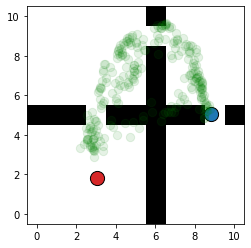

In [39]:
# Get sample condition
occdims = (11, 11)

sample_idx = 2290
sample_X, sample_C = testDataset[sample_idx]
sample = decompose(testDataset[sample_idx], occdims=occdims, verbose=True)
printSample(sample)

# Convert to length-1 batches for model compatability
sample_C = torch.unsqueeze(sample_C, 0)

# Sample latent space
z_dim = model.latent_size
z = torch.Tensor(np.random.randn(batchSize, z_dim))
sample_C = torch.Tensor(np.tile(sample_C, (batchSize, 1)))
model.to("cpu")
model.eval()
with torch.no_grad():
    res = model.decoder(z, sample_C)

# Plot
# fig, axs = axs.show()
# plt.imshow(sample["grid"].T);
plt.scatter((sample["init"][0]*occdims[1])-1, (sample["init"][1]*occdims[0])-0, 
            s=200, color="tab:red", edgecolors="black")
plt.scatter((sample["goal"][0]*occdims[1])-1, (sample["goal"][1]*occdims[0])-0, 
            s=200, color="tab:blue", edgecolors="black")
plt.scatter((res[:,0]*occdims[1])-1, (res[:,1]*occdims[0])-0, color="green", s=70, alpha=0.1)
plt.imshow(sample["grid"].T, cmap='gray', origin='lower')
